# Auto Insurance  Prediction

Make a prediction on the dataset Auto Insurance based on the Kaggle competition: https://www.kaggle.com/c/auto-insurance-fall-2017

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier

#Readind data
url_train = "train_auto.csv"
url_test  = "test_auto.csv"
train_auto= pd.read_csv(url_train,sep=',',index_col='INDEX')
test_auto = pd.read_csv(url_test,sep=',')
test_auto[['TARGET_FLAG','TARGET_AMT']] = pd.read_csv(url_test,sep=r',+',usecols=[1,2],engine='python')
test_auto = test_auto.set_index('INDEX')

In [3]:
train_auto.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [4]:
# Preprocesser training dataset
target_columns = ['TARGET_FLAG']
features = [col for col in train_auto.columns if col not in target_columns]

# change string dollar columns to numerical
for col in ['INCOME','OLDCLAIM','BLUEBOOK','HOME_VAL']:
    train_auto[col] = train_auto[col].replace('[\$,]', '', regex=True).astype(float)

#change the missspelled value
train_auto['EDUCATION'] = train_auto['EDUCATION'].replace(to_replace = {'<High School':'z_High School'})

#Encode categorical columns of the training data
for col in features:
    if np.issubdtype('O', train_auto[col].dtype):
        train_auto[col] = LabelEncoder().fit_transform(train_auto[col])

#Filling the missing values using most frequent value
train_auto = train_auto.fillna(train_auto.mean())
#train_auto = pd.DataFrame(SimpleImputer(missing_values='NaN', strategy='most_frequent').fit_transform(train_auto),columns=train_auto.columns, index=train_auto.index)

In [5]:
train_auto.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.000000,67349.000000,0,0.0,1,...,14230.0,11,0,1,4461.0,2,0,3,18.0,0
2,0,0.0,0,43.0,0,11.000000,91449.000000,0,257252.0,1,...,14940.0,1,0,1,0.0,0,0,0,1.0,0
4,0,0.0,0,35.0,1,10.000000,16039.000000,0,124191.0,0,...,4010.0,4,5,0,38690.0,2,0,3,10.0,0
5,0,0.0,0,51.0,0,14.000000,61898.094609,0,306251.0,0,...,15440.0,7,0,1,0.0,0,0,0,6.0,0
6,0,0.0,0,50.0,0,10.499286,114986.000000,0,243925.0,0,...,18000.0,1,5,0,19217.0,2,1,3,17.0,0


In [6]:
# Preprocesser test dataset
features = [col for col in test_auto.columns if col not in target_columns]

# change string dollar columns to numerical
for col in ['INCOME','OLDCLAIM','BLUEBOOK','HOME_VAL']:
    test_auto[col] = test_auto[col].replace('[\$,]', '', regex=True).astype(float)

#change the missspelled value
test_auto['EDUCATION'] = test_auto['EDUCATION'].replace(to_replace = {'<High School':'z_High School'})

#Encode categorical columns of the training data
for col in features:
    if np.issubdtype('O', test_auto[col].dtype):
        test_auto[col] = LabelEncoder().fit_transform(test_auto[col])

#Filling the missing values using most frequent value
test_auto = test_auto.fillna(test_auto.mean())

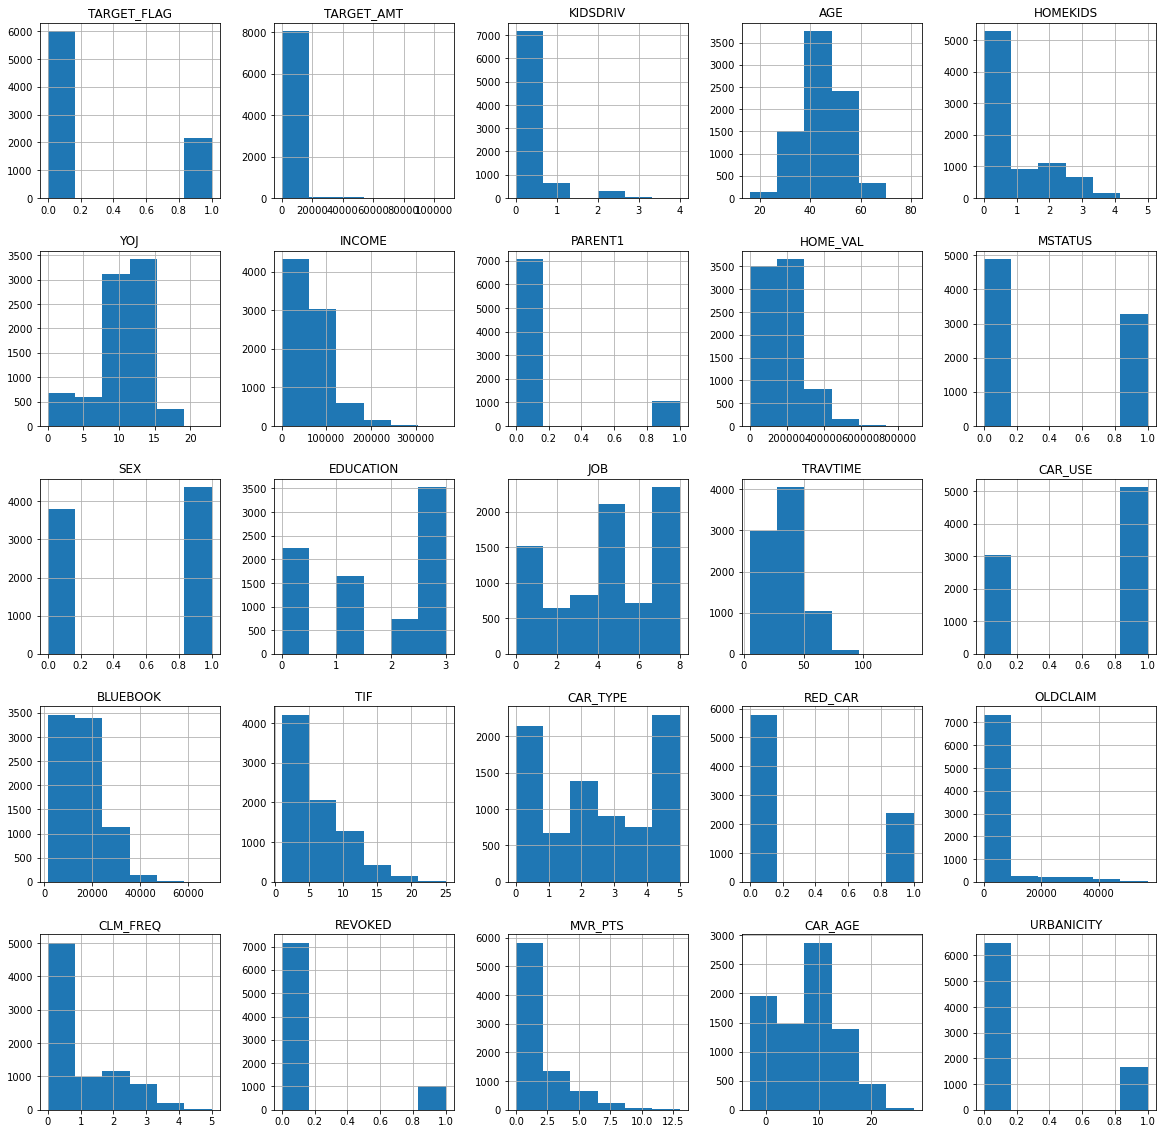

In [7]:
# See data distribution
train_auto.hist(bins=6,figsize=(20,20))
plt.show()

In [8]:
# split X and y by target and features
X,   y         = train_auto[features], train_auto[target_columns]
X_test, y_test = test_auto[features], test_auto[target_columns]

In [9]:
# Choose Learning Methods:
# list of classifiers
names = [ "KNeighbors", "Random Forest", "SVC", "Neural Net" ]

k = int(len(X)**0.5)
classifiers = [
    KNeighborsClassifier(n_neighbors=k, weights='distance'),
    RandomForestClassifier(class_weight='balanced',n_estimators=20),
    SVC(class_weight='balanced',C=1),
    MLPClassifier(alpha=0.1, max_iter=6000)
    ]

In [13]:
# Train models and give accuracy and time information
start = time.time()
print('Model\t\t\t Score\t\t\t time(s)')
print('\n')
scores = []

for name, clf in zip(names, classifiers):
        print(name, end='')
        clf.fit(X, y['TARGET_FLAG'])
        result = clf.predict(X)
        score  = f1_score(y['TARGET_FLAG'],result,average='weighted')
        print('\t\t', round(score*100, 1), '%', '\t\t', round(time.time() - start, 3))
        scores.append(score) 
        start = time.time()

Model			 Score			 time(s)


KNeighbors		 100.0 % 		 1.445
Random Forest		 100.0 % 		 0.142
SVC		 91.4 % 		 9.443
Neural Net		 91.7 % 		 1.331


## Apply Gridsearch + CV with the Random Forest method

In [14]:
# Choose classifier RFC
rfc=RandomForestClassifier(random_state=50)
# Choose param space
param_grid = { 
    'n_estimators': [10, 50],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [5,6],
    'criterion' :['gini', 'entropy']
}
# GridSearch + CV
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y['TARGET_FLAG'])
# Get best_params
rfc1=RandomForestClassifier(random_state=50, max_features=CV_rfc.best_params_['max_features'], \
                            n_estimators=CV_rfc.best_params_['n_estimators'],\
                            max_depth=CV_rfc.best_params_['max_depth'], criterion=CV_rfc.best_params_['criterion'])
rfc1.fit(X, y['TARGET_FLAG'])

# Setting up the output DataFrame
y_target = pd.DataFrame({'INDEX':X_test.index,'TARGET_FLAG':np.zeros(len(X_test.index))})
y_target['TARGET_FLAG']=rfc1.predict(X_test)
y_target = y_target.set_index('INDEX')

In [15]:
#Print y_target result
y_target.to_csv('TARGET_FLAG.csv')